In [1]:
from datetime import date, timedelta
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
from pylr2 import regress2
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf, col
import statsmodels.api as sm
import statsmodels.formula.api as smf
import rioxarray as rxr

In [2]:
from src import constants
from src.data import spark_postgis
from src.utils import raster_utils

## 0. Setup

In [3]:
spark = spark_postgis.get_spark()

24/01/04 14:57:56 WARN Utils: Your hostname, sherwood resolves to a loopback address: 127.0.1.1; using 128.232.93.0 instead (on interface enp193s0f0np0)
24/01/04 14:57:56 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
:: loading settings :: url = jar:file:/home/ah2174/biomass-degradation/venv/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/ah2174/.ivy2/cache
The jars for the packages stored in: /home/ah2174/.ivy2/jars
org.apache.sedona#sedona-python-adapter-3.0_2.12 added as a dependency
org.datasyslab#geotools-wrapper added as a dependency
net.postgis#postgis-jdbc added as a dependency
net.postgis#postgis-geometry added as a dependency
org.postgresql#postgresql added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-8a494158-7433-4be0-8bef-a70dfa9b61a1;1.0
	confs: [default]
	found org.apache.sedona#sedona-python-adapter-3.0_2.12;1.3.1-incubating in central
	found org.locationtech.jts#jts-core;1.18.2 in central
	found org.wololo#jts2geojson;0.16.1 in central
	found org.apache.sedona#sedona-core-3.0_2.12;1.3.1-incubating in central
	found org.apache.sedona#sedona-common;1.3.1-incubating in central
	found org.apache.sedona#sedona-sql-3.0_2.12;1.3.1-incubating in central
	found org.scala-lang.modules#scala-collection-compat_2.12;2.5.0 in central
	found org.data

24/01/04 14:57:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/01/04 14:57:58 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/01/04 14:57:58 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
24/01/04 14:57:58 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


In [4]:
degrade_sdf = spark.read.parquet((constants.RESULTS_PATH / "gedi_degradation_radd_singlelayer").as_posix())
@udf(returnType=IntegerType())
def get_days(time_delta):
  return time_delta.days

degrade_sdf = degrade_sdf.withColumn("time_diff", (degrade_sdf["t2_absolute_time"] - degrade_sdf["t1_absolute_time"]))
degrade_sdf = degrade_sdf.withColumn("time_diff", get_days(col("time_diff")))
degrade_sdf = degrade_sdf.filter(degrade_sdf["t1_agbd_a0"] != 0)
radd_df = gpd.GeoDataFrame(degrade_sdf.toPandas(), geometry="t2_geom").copy()
radd_df.loc[radd_df.control_disturbance > 0, "sample_grp"] = "control"
# Note: points may have a control disturbance as well as a measured disturbance.
# in that case, we include them in the treatment group; we don't care that they
# were also disturbed at another, unmeasured time.
radd_df.loc[radd_df.measured_disturbance > 0, "sample_grp"] = "treatment"
print(len(radd_df))
print(len(radd_df[radd_df["sample_grp"] == "treatment"]))
print(len(radd_df[radd_df["sample_grp"] == "control"]))

40787
6999
33788


In [5]:
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf, col
degrade_sdf = spark.read.parquet((constants.RESULTS_PATH / "gedi_degradation_afc_2022").as_posix())
@udf(returnType=IntegerType())
def get_days(time_delta):
  return time_delta.days

degrade_sdf = degrade_sdf.withColumn("time_diff", (degrade_sdf["t2_absolute_time"] - degrade_sdf["t1_absolute_time"]))
degrade_sdf = degrade_sdf.withColumn("time_diff", get_days(col("time_diff")))
degrade_sdf = degrade_sdf.filter(degrade_sdf["t1_agbd_a0"] != 0)
afc_df = gpd.GeoDataFrame(degrade_sdf.toPandas(), geometry="t2_geom").copy()
afc_df.loc[afc_df.control_disturbance > 0, "sample_grp"] = "control"
# Note: points may have a control disturbance as well as a measured disturbance.
# in that case, we include them in the treatment group; we don't care that they
# were also disturbed at another, unmeasured time.
afc_df.loc[afc_df.measured_disturbance > 0, "sample_grp"] = "treatment"
print(len(afc_df))
print(len(afc_df[afc_df["sample_grp"] == "treatment"]))
print(len(afc_df[afc_df["sample_grp"] == "control"]))

57812
3877
53935


In [6]:
def temporal_adjust(df_orig):
    bins = np.arange(0, 1200, 60)
    df_orig["time_diff_bin"] = pd.cut(df_orig["time_diff"], bins=bins)
    treatment_dist = df_orig[df_orig.sample_grp == "treatment"].groupby("time_diff_bin").size().reset_index(name="count")

    new_control = []
    for i in range(0, len(treatment_dist)):
        bin, count = treatment_dist.iloc[i]["time_diff_bin"], treatment_dist.iloc[i]["count"]
        d = df_orig[(df_orig.sample_grp == "control") & (df_orig.time_diff_bin == bin)]
        if len(d) < count:
            count = len(d)
        new_control.append(d.sample(count, replace=False))

    new_control = pd.concat(new_control)
    return pd.concat([new_control, df_orig[df_orig.sample_grp == "treatment"]])

## 1. Hypothesis testing

2.5320434917227744e-63
1.2660217458613872e-63
2.4384105188534962e-26
1.2192052594267481e-26


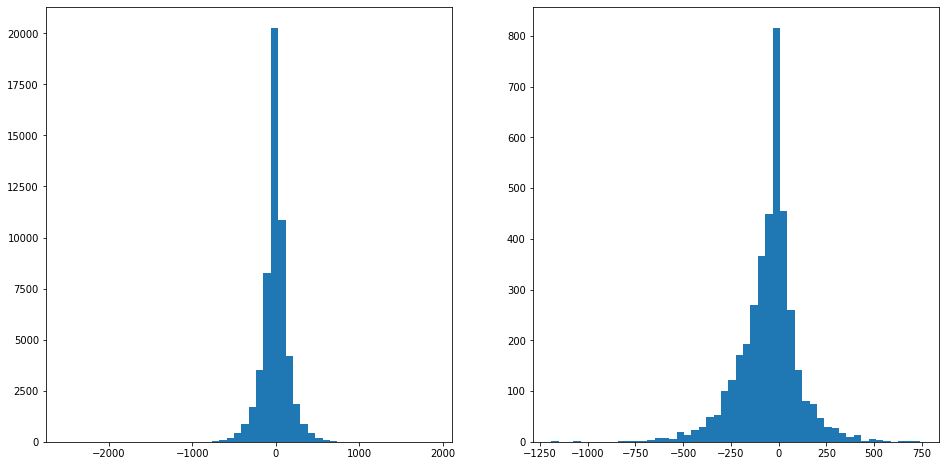

In [7]:
# Hypothesis testing.
import scipy.stats as stats
import numpy as np

degrade_df = afc_df

dist_control = degrade_df[degrade_df.sample_grp == "control"].t2_agbd_a0 - degrade_df[degrade_df.sample_grp == "control"].t1_agbd_a0
dist_treatment = degrade_df[degrade_df.sample_grp == "treatment"].t2_agbd_a0 - degrade_df[degrade_df.sample_grp == "treatment"].t1_agbd_a0

# Plot distribution of S2 - S1 for control and treatment groups.
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
axi = ax[0]
axi.hist(dist_control, bins=50)

axi = ax[1]
axi.hist(dist_treatment, bins=50)

# Welch's t-test. Can we reject the null hypotheses that 
# (1) the mean of the treatment group is equal to the mean of the control group?
res = stats.ttest_ind(dist_control, dist_treatment, equal_var=False)
print(res.pvalue)
# (2) the mean of the control group is greater than the mean of the treatment group?
res = stats.ttest_ind(dist_control, dist_treatment, equal_var=False, alternative="greater")
print(res.pvalue)

# Does it also hold if we look only at single-pixel disturbances?
dist_treatment = degrade_df[(degrade_df.sample_grp == "treatment") & (degrade_df.measured_disturbance == 1)].t2_agbd_a0 - degrade_df[(degrade_df.sample_grp == "treatment") & (degrade_df.measured_disturbance == 1)].t1_agbd_a0

# Welch's t-test
# (1) the mean of the treatment group is equal to the mean of the control group?
res = stats.ttest_ind(dist_control, dist_treatment, equal_var=False)
print(res.pvalue)
# (2) the mean of the treatment group is greater than the mean of the control group?
res = stats.ttest_ind(dist_control, dist_treatment, equal_var=False, alternative="greater")
print(res.pvalue)

## 2. Biomass loss depends on ...

In [8]:
afc_df["agbd_pct_loss"] = (afc_df.t1_agbd_a0 - afc_df.t2_agbd_a0) / (afc_df.t1_agbd_a0) * 100
radd_df["agbd_pct_loss"] = (radd_df.t1_agbd_a0 - radd_df.t2_agbd_a0) / (radd_df.t1_agbd_a0) * 100

#### ... time

In [9]:
from src.data import radd_parser
import scipy.stats as stats
# 0. Days since disturbance
disturb_yydoy = np.array([radd_df.p1_disturb_date, radd_df.p2_disturb_date, radd_df.p3_disturb_date, radd_df.p4_disturb_date, radd_df.p5_disturb_date, radd_df.p6_disturb_date, radd_df.p7_disturb_date, radd_df.p8_disturb_date, radd_df.p9_disturb_date]).T.astype(float)
disturb_yydoy[disturb_yydoy == 0] = np.nan
mode_disturb_yydoy = stats.mode(disturb_yydoy, axis=1, nan_policy='omit', keepdims=True)[0].squeeze()
print(mode_disturb_yydoy.shape)
print(mode_disturb_yydoy)
for i in range(mode_disturb_yydoy.shape[0]):
    radd_df.loc[i, "mode_disturb_dt"] = radd_parser.yydoy_to_datetime(mode_disturb_yydoy[i])
print(radd_df.mode_disturb_dt)

(40787,)
[20244. 22192. 20264. ... 20289. 21282. 21205.]
0        2020-08-31
1        2022-07-11
2        2020-09-20
3        2022-08-17
4        2020-11-21
            ...    
40782    2021-08-03
40783    2021-04-12
40784    2020-10-15
40785    2021-10-09
40786    2021-07-24
Name: mode_disturb_dt, Length: 40787, dtype: object


In [10]:
radd_df["days_since_disturbance"] = (radd_df.t2_absolute_time.apply(lambda x: x.date()) - radd_df.mode_disturb_dt).dt.days
# At the moment, because of the way we record the disturbance date, some of the days_since_disturbance
# values are negative, even in the treatment set.
# This is because the control disturb_date is also recorded whenever it is applicable
# (and AFTER the treatment disturb_date in the code, so it will override the treatment disturb_date).
# Many treatment disturbance pairs also have unmeasured disturbances at another time.
# For now, only include disturbances with a positive number of days since disturbance.
days_since_disturb_df = radd_df[(radd_df.sample_grp == "treatment") & (radd_df.days_since_disturbance >= 0)]
days_since_disturb_df["months_since_disturbance"] = days_since_disturb_df.days_since_disturbance // 30

/home/ah2174/gedi-disturbance/venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1456: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


#### ... intensity

In [11]:
degrade_sdf = spark.read.parquet((constants.RESULTS_PATH / "gedi_degradation_afc_intensity").as_posix())

intensity_df = gpd.GeoDataFrame(degrade_sdf.toPandas(), geometry="t2_geom").copy()
intensity_df = intensity_df[intensity_df["t1_agbd_a0"] != 0]
intensity_df.loc[intensity_df.control_disturbance > 0, "sample_grp"] = "control"
# Note: points may have a control disturbance as well as a measured disturbance.
# in that case, we include them in the treatment group; we don't care that they
# were also disturbed at another, unmeasured time.
intensity_df.loc[intensity_df.measured_disturbance > 0, "sample_grp"] = "treatment"
print(len(intensity_df))
print(len(intensity_df[intensity_df["sample_grp"] == "treatment"]))
print(len(intensity_df[intensity_df["sample_grp"] == "control"]))

61387
4083
57304


In [12]:
intensity_df = intensity_df[(intensity_df.sample_grp == "treatment")]
intensity_df["agbd_pct_loss"] = (intensity_df.t1_agbd_a0 - intensity_df.t2_agbd_a0) / (intensity_df.t1_agbd_a0) * 100
intensity_df.disturb_intensity_old = intensity_df.disturb_intensity.copy()
intensity_df.disturb_intensity = intensity_df.disturb_intensity * 4 / intensity_df.measured_disturbance

bins = np.concatenate([np.arange(0, 0.1, 0.025), np.arange(0.1,0.71, 0.1)])
print(bins)
intensity_df["disturb_bin"] = pd.cut(intensity_df.disturb_intensity, bins=bins, labels=bins[:-1])
print(intensity_df[['disturb_intensity', 'disturb_bin']])
treatment_df = intensity_df[intensity_df.sample_grp == "treatment"]
print(intensity_df.disturb_bin.value_counts())

[0.    0.025 0.05  0.075 0.1   0.2   0.3   0.4   0.5   0.6   0.7  ]
       disturb_intensity disturb_bin
11              0.125000       0.100
38              0.090909       0.075
39              0.000000         NaN
40              0.000000         NaN
42              0.000000         NaN
...                  ...         ...
62231           0.052632       0.050
62233           0.026154       0.025
62237           0.055000       0.050
62349           0.000000         NaN
62351           0.055556       0.050

[4083 rows x 2 columns]
0.025                  700
0.05                   671
0.1                    511
0.07500000000000001    311
0.2                    229
0.0                    199
0.30000000000000004    141
0.4                     91
0.5                     52
0.6                     40
Name: disturb_bin, dtype: int64


/home/ah2174/gedi-disturbance/venv/lib/python3.10/site-packages/geopandas/geodataframe.py:199: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super().__setattr__(attr, val)


### Now bootstrap and plots

In [13]:
def bootstrap_and_plot_extent(degrade_df, axi):
    treatment_df = degrade_df[degrade_df.sample_grp == "treatment"]
    control_df = degrade_df[degrade_df.sample_grp == "control"]
    # Bootstrap confidence intervals for the median percent AGBD change.
    k_dist = np.max(degrade_df.measured_disturbance)
    # 1. Bootstrap sample the median pct delta AGBD for each disturbance extent and the control.
    n = 100
    medians = np.zeros((n, k_dist+1))
    for i in range(n):
        medians[i, 0] = np.median(control_df.agbd_pct_loss.sample(frac=1, replace=True))
        for j in range(k_dist):
            medians[i, j+1] = np.median(treatment_df[treatment_df.measured_disturbance == j+1].agbd_pct_loss.sample(frac=1, replace=True))
    print(medians.mean(axis=0))

    # 2. Compute the 95% confidence interval for each median for plotting.
    ci = np.zeros((2, k_dist+1))
    for i in range(k_dist+1):
        ci[:, i] = np.percentile(medians[:, i], [2.5, 97.5])
    print(ci)

    # 3. Compute a regression line for disturbance extent vs. median pct delta AGBD.
    intercepts = np.zeros(n)
    slopes = np.zeros(n)
    rs = np.zeros(n)
    pvals = np.zeros(n)
    for i in range(n):
        model = sm.OLS(medians[i, 1:k_dist+1], sm.add_constant(np.arange(1, k_dist+1)))
        results = model.fit()
        intercepts[i] = results.params[0]
        slopes[i] = results.params[1]
        rs[i] = results.rsquared
        pvals[i] = results.pvalues[1]

    # 4. Plot the distribution of median pct delta AGBD for each disturbance extent.
    axi.errorbar(np.arange(0, k_dist+1), medians.mean(axis=0), yerr=np.abs(ci - medians.mean(axis=0)), fmt='o', ecolor="tab:blue", capsize=3, zorder=1)
    axi.scatter(0, medians.mean(axis=0)[0], color="tab:green", zorder=10)
    axi.scatter(np.arange(1, k_dist+1), medians.mean(axis=0)[1:k_dist+1], color="tab:orange", zorder=10)
    # Plot a sample of the regression lines
    sample = np.random.choice(np.arange(n), size=25)
    for i in sample:
        axi.plot(np.arange(1, k_dist+1), intercepts[i] + slopes[i] * np.arange(1, k_dist+1), color="gray", alpha=0.2, zorder=5)
    axi.plot(np.arange(1, k_dist+1), intercepts.mean() + slopes.mean() * np.arange(1, k_dist+1), color="black", zorder=6)

    axi.set_xticks(np.arange(0, k_dist+1))
    axi.set_xlabel(f"Disturbance extent (1-{k_dist})")
    axi.set_ylabel("Median percent AGBD loss")
    axi.set_title(f"Biomass loss by disturbance extent (1-{k_dist})")

    legend_elements = [
            Line2D([0], [0], marker='o', color='tab:orange', label="Treatment",
                markerfacecolor='tab:orange', markersize=7, linestyle='None'),
            Line2D([0], [0], marker='o', color='tab:green', label="Control",
                markerfacecolor='tab:green', markersize=7, linestyle='None'),
            Line2D([0], [0], color='black', linewidth=3, label=f"y = {slopes.mean():.1f}x + {intercepts.mean():.1f}\n$R^2$ = {rs.mean():.2f}, p = {pvals.mean():.3f}"),
        ]
    axi.legend(loc="lower right", handles=legend_elements)
    print(rs.mean())
    print(pvals.mean())

In [14]:
def bootstrap_and_plot_time(degrade_df, axi):
    k_months = 23 # 0-22 months since disturbance. Beyond 22 months we don't have enough data.
    # 1. Bootstrap sample the median pct delta AGBD for each number of months since disturbance.
    n = 100

    # with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        # print(days_since_disturb_df.months_since_disturbance.value_counts().sort_index())
    medians = np.zeros((n, k_months))
    for i in range(n):
        for j in range(k_months):
            medians[i, j] = np.median(days_since_disturb_df[days_since_disturb_df.months_since_disturbance == j].agbd_pct_loss.sample(frac=1, replace=True))

    # 2. Compute the 95% confidence interval for each median for plotting.
    ci = np.zeros((2, k_months))
    for i in range(k_months):
        ci[:, i] = np.percentile(medians[:, i], [2.5, 97.5])

    # 3. Plot the distribution of median pct delta AGBD for each time since disturbance.

    axi.errorbar(np.arange(k_months), medians.mean(axis=0), yerr=np.abs(ci - medians.mean(axis=0)), fmt='o', ecolor="tab:blue", capsize=3, zorder=1)
    axi.scatter(0, medians.mean(axis=0)[0], color="tab:green", zorder=10)
    axi.scatter(np.arange(k_months), medians.mean(axis=0), color="tab:orange", zorder=10)

    # Try fitting a curve ...
    # intercept, linear, quadratic
    coeffs = np.zeros((n, 3))
    adjrs = np.zeros(n)
    # intercept, linear, quadratic
    ps = np.zeros((n, 3))
    for i in range(n):
        data = pd.DataFrame({'y': medians[i, :], 'x': np.arange(k_months)})
        model = smf.ols(formula = 'y ~ np.power(x, 2) + x', data=data)
        # model = smf.ols(formula = 'y ~ x', data=data)
        results = model.fit()
        coeffs[i, :] = results.params
        adjrs[i] = results.rsquared_adj
        ps[i] = results.pvalues[:3]

    print(coeffs.mean(axis=0))
    sample = np.random.choice(np.arange(n), size=25)
    for i in sample:
        axi.plot(np.arange(k_months), coeffs[i, 0] + coeffs[i, 1] * np.power(np.arange(k_months), 2) + coeffs[i, 2] * np.arange(k_months), color="gray", alpha=0.2, zorder=5)
    axi.plot(np.arange(k_months), coeffs.mean(axis=0)[0] + coeffs.mean(axis=0)[1] * np.power(np.arange(k_months), 2) + coeffs.mean(axis=0)[2] * np.arange(k_months), color="black", linewidth=3, zorder=6)

    axi.set_xticks(np.arange(0, k_months, 3))
    axi.set_xlabel(f"Months (rounded) since disturbance")
    axi.set_ylabel("Median percent AGBD loss")
    axi.set_ylim(None, 105)
    axi.set_title(f"Biomass loss by time since disturbance")

    legend_elements = [
            Line2D([0], [0], marker='o', color='tab:orange', label="Treatment",
                markerfacecolor='tab:orange', markersize=7, linestyle='None'),
            Line2D([0], [0], color='black', linewidth=3, label=f"y = {coeffs.mean(axis=0)[0]:.1f} + {coeffs.mean(axis=0)[1]:.1f}x + {coeffs.mean(axis=0)[2]:.1f}$x^2$\nadj-$R^2$ = {adjrs.mean():.2f}"),
        ]
    axi.legend(loc="lower right", handles=legend_elements)
    print(adjrs.mean())
    print(ps.mean(axis=0))

In [15]:
def bootstrap_and_plot_intensity(degrade_df, bins, axi):
    import statsmodels.formula.api as smf

    # Bootstrap confidence intervals for the median percent AGBD change.
    k_dist = len(bins) - 1
    bin_vals = bins[:-1]

    # 1. Bootstrap sample the median pct delta AGBD for each disturbance extent and the control.
    n = 100
    medians = np.zeros((n, k_dist))
    for i in range(n):
        for j, b in enumerate(bin_vals):
            medians[i, j] = np.median(treatment_df[treatment_df.disturb_bin == b].agbd_pct_loss.sample(frac=1, replace=True))
    print(medians.mean(axis=0))

    # 2. Compute the 95% confidence interval for each median for plotting.
    ci = np.zeros((2, k_dist))
    for i in range(k_dist):
        ci[:, i] = np.percentile(medians[:, i], [2.5, 97.5])
    print(ci)

    # 3. Compute a regression line for disturbance extent vs. median pct delta AGBD.
    intercepts = np.zeros(n)
    slopes = np.zeros(n)
    rs = np.zeros(n)
    pvals = np.zeros(n)

    def fun(a, b, xs):
        return a + b * np.sqrt(xs)

    for i in range(n):
        df = pd.DataFrame({'intensity': bin_vals, 'agbd_pct_loss': medians[i,:]})
        model = smf.ols('agbd_pct_loss ~ np.sqrt(intensity)', df)
        results = model.fit()
        intercepts[i] = results.params[0]
        slopes[i] = results.params[1]
        rs[i] = results.rsquared
        pvals[i] = results.pvalues[1]

    # 4. Plot the distribution of median pct delta AGBD for each disturbance extent.
    axi.errorbar(bin_vals, medians.mean(axis=0), yerr=np.abs(ci - medians.mean(axis=0)), fmt='o', ecolor="tab:blue", capsize=3, zorder=1)
    axi.scatter(bin_vals, medians.mean(axis=0), color="tab:orange", zorder=10)
    # Plot a sample of the regression lines
    sample = np.random.choice(np.arange(n), size=25)
    for i in sample:
        axi.plot(bin_vals, fun(intercepts[i], slopes[i], bin_vals), color="gray", alpha=0.2, zorder=5)
    axi.plot(bin_vals, fun(intercepts.mean(), slopes.mean(), bin_vals), color="black", zorder=6)

    labels = pd.cut(degrade_df.disturb_intensity * 4, bins=bins).cat.categories
    axi.set_xticks(bin_vals[[0,2,4,5,6,7,8]], labels=labels.astype(str)[[0,2,4,5,6,7,8]], rotation=-45)
    axi.set_xlabel(f"Disturbance intensity index")
    axi.set_ylabel("Median percent AGBD loss")
    axi.set_title(f"Biomass loss by disturbance intensity")

    legend_elements = [
            Line2D([0], [0], color='black', linewidth=3, label=f"y = {slopes.mean():.1f} * sqrt(x) + {intercepts.mean():.1f}\n$R^2$ = {rs.mean():.2f}, p = {pvals.mean():.4f}"),
        ]
    axi.legend(bbox_to_anchor=(1.0, 0.215), handles=legend_elements)
    print(rs.mean())
    print(pvals.mean())

[ 7.33087591 46.05761701 46.03239052 69.24579474 61.74316795 64.21132799
 78.53964333 72.48705688 82.27838857 99.9206239 ]
[[ 6.59907038 40.3867259  33.38132643 65.02092421 54.19999542 52.47513529
  73.9007843  63.66381342 75.78225607 99.82134636]
 [ 8.16712158 51.35386491 54.728249   74.24700082 70.19353278 74.13585413
  83.71395075 80.8852101  89.37390914 99.97318782]]
0.8127059602333385
0.0012307211341204508
[ 3.17611907 22.65986587 30.81269516 43.12182286 64.1742696 ]
[[ 2.59360006 20.25440334 23.81486444 28.34406854 58.5633068 ]
 [ 3.73142886 25.85632389 39.06072947 54.08652434 74.13618054]]
0.9166759065383494
0.04375811162365233
[ 7.02465059e+01 -6.39545492e-02  2.22404623e+00]
0.21956347174030863
[1.61736835e-05 3.60864372e-01 1.59722031e-01]
[ 6.7394306  22.53352723 14.53541003 35.75157779 48.68262128 57.0617056
 60.55193698 79.5688954  82.86800553 96.18365611]
[[-13.30312844  15.71238373   6.66784331  25.5176007   40.61999224
   44.98480966  38.49238146  49.07116578  58.519840

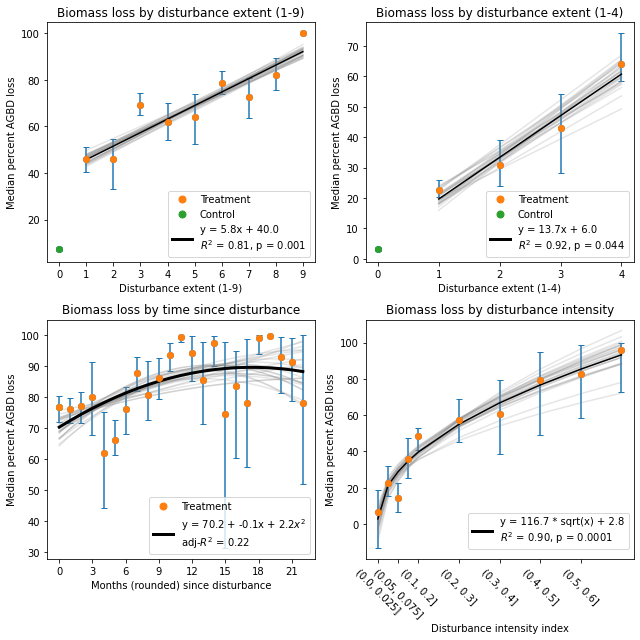

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))
################################################################################
# A. RADD disturbance extent
################################################################################
axi = ax[0][0]
bootstrap_and_plot_extent(radd_df, axi)

################################################################################
# B. AFC disturbance extent
################################################################################
axi = ax[0][1]
bootstrap_and_plot_extent(afc_df, axi)

################################################################################
# C. RADD time since disturbance
################################################################################
axi = ax[1][0]
bootstrap_and_plot_time(radd_df, axi)

################################################################################
# D. AFC disturbance intensity
################################################################################
axi = ax[1][1]
bootstrap_and_plot_intensity(intensity_df, bins, axi)

plt.tight_layout()

In [17]:
# Check that there is still statistically significant positive correlation
# even if the disturbance extent is constant.
from scipy.stats import pearsonr
bins = np.concatenate([[0.0, 0.05], np.arange(0.1,0.61, 0.1)])
print(bins)
intensity_df["disturb_bin"] = pd.cut(intensity_df.disturb_intensity, bins=bins, labels=bins[:-1])
k_dist = len(bins) - 1
k_extent = np.max(intensity_df.measured_disturbance)
prs = []
for extent in range(1,k_extent+1):
    tdf = intensity_df[intensity_df.measured_disturbance == extent]
    print(tdf.disturb_bin.value_counts())
    n = 100
    medians = np.zeros((n, k_dist))
    for i in range(n):
        for j, b in enumerate(bins[:-1]):
            medians[i, j] = np.median(tdf[tdf.disturb_bin == b].agbd_pct_diff.sample(frac=1, replace=True))
    print(medians.mean(axis=0))
    prs.append(pearsonr(bins[:-1], medians.mean(axis=0)))

for pr in prs:
    print(pr)


[0.   0.05 0.1  0.2  0.3  0.4  0.5  0.6 ]
0.05                   620
0.0                    388
0.1                    251
0.2                    101
0.30000000000000004     60
0.4                     48
0.5                     23
Name: disturb_bin, dtype: int64


AttributeError: 'GeoDataFrame' object has no attribute 'agbd_pct_diff'